# The Binance API

# Order book data

## Introduction

Hallo data miners! ⛏

The second episode of this chapter regarding the Binance API will explore just one, always useful, info you can retrieve: the Order Book. If you read these articles, you are probably very familiar with the concept of Order Book so I will not bother you with all the usual boiler-plate introduction on: what is an Order Book? How Orders are matched in Finance? and bla and bla and bla.

I do not have to rank on Google so I will keep my posts as I think it's better: concise. Very few concepts per article, some small examples and max 5 minutes read. 





In [18]:
import json
import requests

r = requests.get("https://api.binance.com/api/v3/depth",params=dict(symbol="AXSBUSD"))
response = r.json()
response

{'lastUpdateId': 715148287,
 'bids': [['17.80000000', '247.51000000'],
  ['17.79000000', '447.52000000'],
  ['17.78000000', '529.17000000'],
  ['17.77000000', '280.98000000'],
  ['17.76000000', '56.52000000'],
  ['17.75000000', '720.43000000'],
  ['17.74000000', '7.04000000'],
  ['17.73000000', '5.76000000'],
  ['17.72000000', '81.37000000'],
  ['17.71000000', '1786.23000000'],
  ['17.70000000', '47.81000000'],
  ['17.69000000', '151.04000000'],
  ['17.68000000', '108.29000000'],
  ['17.67000000', '615.04000000'],
  ['17.66000000', '25.49000000'],
  ['17.65000000', '9.14000000'],
  ['17.64000000', '49.47000000'],
  ['17.63000000', '785.36000000'],
  ['17.62000000', '382.42000000'],
  ['17.61000000', '44.90000000'],
  ['17.60000000', '323.12000000'],
  ['17.59000000', '148.61000000'],
  ['17.58000000', '9.28000000'],
  ['17.57000000', '0.57000000'],
  ['17.56000000', '43.99000000'],
  ['17.55000000', '0.57000000'],
  ['17.54000000', '6.37000000'],
  ['17.53000000', '69.10000000'],
  ['1

Let's just construct the bid and ask DataFrames by reading the "bid"/"ask" key of the response. Using the pandas method ```from_records``` the corresponding list can be transformed into a DataFrame with a snap! 

As the name suggests, with the method ```concat``` we can concatenate the two DataFrames.

In [19]:
import pandas as pd

# define the bid/ask datframes by reading the bid/ask keys of the response
# and the pandas constructor method from_records. Add also a column "side".
df_bid = pd.DataFrame.from_records(response['bids'], columns=['price', 'quantity']).astype('float')
df_bid['side'] = 'bid'

df_ask = pd.DataFrame.from_records(response['asks'], columns=['price', 'quantity']).astype('float')
df_ask['side'] = 'ask'

# concatenate the dataframes
# for the bid we first sort the dataframe in ascending order
# then we select the last 5 rows of bid and the first five of ask
df = pd.concat([df_bid.sort_values(by=['price'])[-5:], df_ask[:5]], ignore_index=True)
df

,price,quantity,side
0,17.76,56.52,bid
1,17.77,280.98,bid
2,17.78,529.17,bid
3,17.79,447.52,bid
4,17.80,247.51,bid
5,17.82,153.06,ask
6,17.83,159.49,ask
7,17.84,354.50,ask
8,17.85,485.08,ask
9,17.86,364.75,ask


In [20]:
import ipywidgets as widgets

# create a jupyter widget with the table html
widgets.HTML(value=df.to_html())

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></…

In [22]:
st=df.style.hide_index()
st = st.hide_columns(['side'])
widgets.HTML(value=st.to_html())

HTML(value='<style type="text/css">\n</style>\n<table id="T_bb993_">\n  <thead>\n    <tr>\n      <th class="co…

## Draw the table in black green and red colors

In [78]:
df_mask = df.copy(deep=True)
df_mask[df['side'] == 'bid'] = 'bid'
df_mask[df['side'] == 'ask'] = 'ask'

s = df.style.set_table_styles([
    {'selector': 'th:not(.index_name)','props':'text-align:center; color:grey;background-color:#373737'},
    {'selector': 'td','props':'text-align:center; background-color:#2d2d2d;font-weight:bold'},
    {'selector':'.bid','props':'color:#086623'},
    {'selector':'.ask','props':'color:red'},
],overwrite=False)

s.set_td_classes(df_mask)

tab = widgets.HTML(value=s.to_html())

## We add the bars

In [79]:
idxs = df.index[df['side'] == 'bid'].tolist()
idx = pd.IndexSlice
s.bar(subset=idx[:idxs[-1],'quantity'], color='#dbeac5')
s.bar(subset=idx[idxs[-1]+1:,'quantity'], color='#ff9090')

,price,quantity,side
0,29140.170000,0.077480,bid
1,29140.710000,0.004080,bid
2,29140.740000,0.019170,bid
3,29141.870000,0.140260,bid
4,29143.240000,0.765800,bid
5,29143.250000,0.200790,ask
6,29143.390000,0.002370,ask
7,29144.580000,0.192890,ask
8,29144.590000,0.034310,ask
9,29144.650000,0.440000,ask


## We draw the widget Here

In [73]:
%%html
<style>
    .box_style{
        width:100%;
        border : 0px solid red;
        height: auto;
        background-color:#373737;
    }
</style>

In [70]:
from ipywidgets import Layout

hBox = widgets.HBox([tab],layout=Layout(justify_content= 'center'))
hBox.add_class("box_style")
hBox

## This is the function with the final style pipeline to be applied to the Dataframe

In [67]:
def style_pipe(df):
    s= df.style.hide_index().hide_columns(['side'])

    df_mask = df.copy(deep=True)
    df_mask[df['side'] == 'bid'] = 'bid'
    df_mask[df['side'] == 'ask'] = 'ask'

    s.set_table_styles([
        {'selector': 'th:not(.index_name)','props':'text-align:center; color:grey;background-color:#373737'},
        {'selector': 'td','props':'text-align:center; background-color:#2d2d2d;font-weight:bold'},
        {'selector':'.bid','props':'color:green'},
        {'selector':'.ask','props':'color:red'},
    ],overwrite=False)

    s.set_td_classes(df_mask)   

    idxs = df.index[df['side'] == 'bid'].tolist()
    idx = pd.IndexSlice
    s.bar(subset=idx[:idxs[-1],'quantity'], color='#dbeac5')
    s.bar(subset=idx[idxs[-1]+1:,'quantity'], color='#ff9090')

    return s 

Then you launch the loop that updates the widget

In [68]:
import time

count=0
while count<100:
    #time.sleep(5)
    r = requests.get("https://api.binance.com/api/v3/depth",params=dict(symbol="BTCBUSD"))
    response = r.json()

    df_bid = pd.DataFrame.from_records(response['bids'], columns=['price', 'quantity']).astype('float')
    df_bid['side'] = 'bid'

    df_ask = pd.DataFrame.from_records(response['asks'], columns=['price', 'quantity']).astype('float')
    df_ask['side'] = 'ask'

    df = pd.concat([df_bid.sort_values(by=['price'])[-5:], df_ask[:5]], ignore_index=True)
    count=count+1
    
    tab.value=style_pipe(df).to_html()

## I try the same with figure widget

In [13]:
import plotly.graph_objects as go

fig = go.Figure()
for df in [df_bid,df_ask]: fig.add_trace(go.Scatter(x=df['price'],y=df['quantity'],mode='markers',marker=dict(size=15*df['quantity'])))
fwidg = go.FigureWidget(fig)

fwidg



FigureWidget({
    'data': [{'marker': {'size': array([1.926075e+01, 5.610000e-02, 1.365000e-02, 3.206100e+00,…

In [14]:
count=0
while count<100:
    #time.sleep(5)
    r = requests.get("https://api.binance.com/api/v3/depth",params=dict(symbol="BTCBUSD"))
    response = r.json()

    df_bid = pd.DataFrame.from_records(response['bids'], columns=['price', 'quantity']).astype('float')
    df_ask = pd.DataFrame.from_records(response['asks'], columns=['price', 'quantity']).astype('float')
    
    bid = fwidg.data[0]
    bid.x = df_bid['price']
    bid.y = df_bid['quantity']
    
    bid = fwidg.data[1]
    bid.x = df_ask['price']
    bid.y = df_ask['quantity']
    
    count=count+1
    
   

In [6]:
df.groupby('side').describe()

price                                                             \
      count     mean       std    min      25%     50%      75%    max   
side                                                                     
ask   100.0  18.8390  0.341182  18.27  18.5575  18.835  19.1125  19.45   
bid   100.0  17.7111  0.347025  17.07  17.4275  17.725  18.0125  18.26   

     quantity                                                              
        count      mean         std   min     25%     50%    75%      max  
side                                                                       
ask     100.0   96.6341  279.124464  0.53  2.5375   8.745  43.49  1766.52  
bid     100.0  201.5327  637.255790  0.60  4.3600  16.530  69.74  4507.90

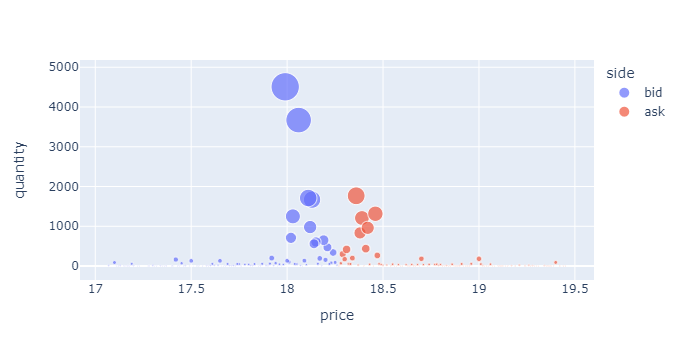

In [7]:
import plotly.express as px
fig = px.scatter(df, x="price", y="quantity", color="side",size='quantity')
fig.show()

In [15]:
df_bid['depth_volume']=df_bid.cumsum().quantity
df_ask['depth_volume']=df_ask.cumsum().quantity
df_ask

rho = (df_bid['depth_volume']-df_ask['depth_volume'])/(df_bid['depth_volume']+df_ask['depth_volume'])
rho

0     0.524047
1     0.202841
2     0.095219
3    -0.011703
4    -0.243635
        ...   
95    0.353895
96    0.349779
97    0.349802
98    0.351572
99    0.351812
Name: depth_volume, Length: 100, dtype: float64

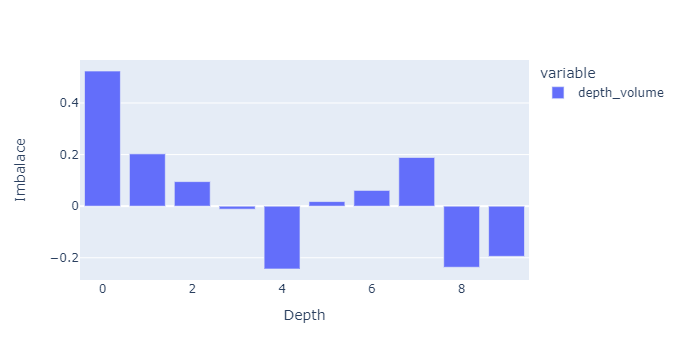

In [18]:
fig = px.bar(rho[:10])
fig.update_xaxes(title_text="Depth")
fig.update_yaxes(title_text="Imbalace")
fig.show()

# New Article on Historic Data

In [23]:
r = requests.get("https://api.binance.com/api/v3/klines",params=dict(symbol="AXSBUSD",interval="1h"))

response = r.json()
cols =['Open_time','Open','High','Low','Close','Volume','Close_time',
'Quote_asset_volume','Number_of_Trades','Taker_buy_base','Taker_buy_quote','Ignore']
df_kline=pd.DataFrame(response,columns=cols)

The server time is: 2022-05-27 12:00:00


In [26]:
from datetime import datetime

def from_str_to_ms(t):
    dt_obj = datetime.strptime(t,'%d-%m-%Y')
    # return int because the date parameters
    # of Binance api are of type 'Long'
    return int(dt_obj.timestamp() * 1000) 

start = from_str_to_ms('25-05-2022')
end = from_str_to_ms('26-05-2022')


r = requests.get("https://api.binance.com/api/v3/klines",params=dict(symbol="AXSBUSD",interval="1m",startTime=int(start),endTime=int(end)))

response = r.json()
cols =['Open_time','Open','High','Low','Close','Volume','Close_time',
'Quote_asset_volume','Number_of_Trades','Taker_buy_base','Taker_buy_quote','Ignore']
df_kline=pd.DataFrame(response,columns=cols)
df_kline

,Open_time,Open,High,Low,Close,Volume,Close_time,Quote_asset_volume,Number_of_Trades,Taker_buy_base,Taker_buy_quote,Ignore
0,1653429600000,21.13000000,21.18000000,21.13000000,21.16000000,213.35000000,1653429659999,4514.49440000,42,145.98000000,3088.75940000,0
1,1653429660000,21.15000000,21.15000000,21.13000000,21.14000000,54.68000000,1653429719999,1155.84360000,5,1.00000000,21.15000000,0
2,1653429720000,21.13000000,21.18000000,21.12000000,21.17000000,297.44000000,1653429779999,6286.95480000,20,46.57000000,985.99410000,0
3,1653429780000,21.17000000,21.20000000,21.17000000,21.20000000,451.03000000,1653429839999,9555.13380000,49,194.10000000,4111.23950000,0
4,1653429840000,21.19000000,21.19000000,21.17000000,21.17000000,5.95000000,1653429899999,126.06150000,2,5.95000000,126.06150000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
495,1653459300000,20.71000000,20.71000000,20.70000000,20.70000000,1.00000000,1653459359999,20.70930000,2,0.00000000,0.00000000,0
496,1653459360000,20.73000000,20.73000000,20.73000000,20.73000000,9.64000000,1653459419999,199.83720000,1,9.64000000,199.83720000,0
497,1653459420000,20.70000000,20.70000000,20.69000000,20.69000000,171.86000000,1653459479999,3556.36600000,11,0.00000000,0.00000000,0
498,1653459480000,20.69000000,20.69000000,20.69000000,20.69000000,0.00000000,1653459539999,0.00000000,0,0.00000000,0.00000000,0


    1499040000000,      // Open time
    "0.01634790",       // Open
    "0.80000000",       // High
    "0.01575800",       // Low
    "0.01577100",       // Close
    "148976.11427815",  // Volume
    1499644799999,      // Close time
    "2434.19055334",    // Quote asset volume
    308,                // Number of trades
    "1756.87402397",    // Taker buy base asset volume
    "28.46694368",      // Taker buy quote asset volume
    "17928899.62484339" // Ignore.

Kline/Candlestick chart intervals:

m -> minutes; h -> hours; d -> days; w -> weeks; M -> months

1m
3m
5m
15m
30m
1h
2h
4h
6h
8h
12h
1d
3d
1w
1M

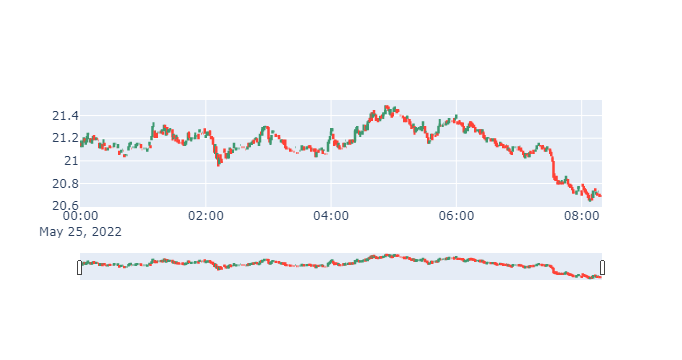

In [30]:
import plotly.graph_objects as go

def ms_to_time(ms):
    return datetime.fromtimestamp(int(ms/1000))

df_kline['Open_time'] = df_kline['Open_time'].apply(ms_to_time)


fig = go.Figure(data=[go.Candlestick(x=df_kline['Open_time'],
                open=df_kline['Open'],
                high=df_kline['High'],
                low =df_kline['Low'],
                close=df_kline['Close'])])

fig.show()